# Benchmarking NVIDIA TX1 using Inception v3

# Environment setup
To measure the current consumption I measured the voltage drop in a resistor.
* The resistance was 1 Ohm ± 1% ([RS0051R000FE12](https://www.mouser.es/productdetail/vishay-dale/rs0051r000fe12?qs=%252b%2f1MMOhkBTf5JUBsk0YDOg==)). Two of them in parallel were used (0.5 Ohm).
* The static current consumption of the setup before starting the inference (i.e. before executing `make VERSION=V1 infer`) was between 130 and 150 mA. This is the power drained by the NVIDIA TX1 Developer Kit running clean the Ubuntu version provided by NVIDIA, connected through Ethernet. For our calculations we've substracted this current to consider only the power consumption corresponding to the AI algorithm.

![Setup](../setup.png)

## Screenshot from the oscilloscope
This screenshot shows the entire duration of the command `make VERSION=v1 infer`. The data that we will be using from the CSV corresponds to the peak in the middle. The last peak corresponds to the result analysis and the first part corresponds to the initialization of the system and the varialbles. We are mainly interested in the middle peak because usually we would not be performing a single inference. 

![Inference](inference.png)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

## Output (accuracy and latency)

In [2]:
! cat output.txt

nvidia@tegra-ubuntu:~/oscw-doc1/jetson$ make infer VERSION=v3

Running inferences on ../data/pic_002.jpg...
(./build/classify_image/classify_image ../data/pic_002.jpg ./model/v3/inception_v3.plan ./model/v3/labels.txt input InceptionV3/Predictions/Reshape_1 inception)
Loading TensorRT engine from plan file...
Preprocessing input...
Executing inference engine...
Execution time: 209.219 ms

The top-5 indices are: 
0. 288:lynx, catamount (57.587%)
1. 283:tiger cat (16.6933%)
2. 282:tabby, tabby cat (14.0419%)
3. 286:Egyptian cat (0.963857%)
4. 284:Persian cat (0.278385%)


In [3]:
latency = 209.219

## Parse raw data 

In [4]:
df_params = pd.read_csv("inference.csv", nrows=1, usecols=['Start', 'Increment'])
period_ms = df_params['Increment'][0] * 1000
period_ms

0.5

In [5]:
df_val = pd.read_csv("inference.csv", skiprows=[1], usecols=['X', 'CH1', 'CH2'])
df_val.loc[:, 'X'] *= period_ms

df_val.rename(index=str, columns={'X': 'time [ms]', 'CH1': 'vout [V]', 'CH2': 'vin [V]'}, inplace=True)
df_val[:10]

,time [ms],vout [V],vin [V]
0,0.0,9.54,9.59
1,0.5,9.57,9.64
2,1.0,9.56,9.60
3,1.5,9.54,9.64
4,2.0,9.57,9.59
5,2.5,9.54,9.64
6,3.0,9.53,9.60
7,3.5,9.57,9.64
8,4.0,9.56,9.64
9,4.5,9.53,9.60


# Obtaining power consumption

In [6]:
R = 0.5 # ohm
static_curr = 130 # [mA] lowest value to consider worst case scenario
df_val['total curr [mA]'] = (df_val['vin [V]'] - df_val['vout [V]']) * 1000 / R
df_val['curr [mA]'] = (df_val['vin [V]'] - df_val['vout [V]']) * 1000 / R - static_curr

df_val['total pow [mW]'] = df_val['total curr [mA]'] * df_val['vout [V]']
df_val['pow [mW]'] = df_val['curr [mA]'] * df_val['vout [V]']
df_val[:10]

,time [ms],vout [V],vin [V],total curr [mA],curr [mA],total pow [mW],pow [mW]
0,0.0,9.54,9.59,100.0,-30.0,954.0,-286.2
1,0.5,9.57,9.64,140.0,10.0,1339.8,95.7
2,1.0,9.56,9.60,80.0,-50.0,764.8,-478.0
3,1.5,9.54,9.64,200.0,70.0,1908.0,667.8
4,2.0,9.57,9.59,40.0,-90.0,382.8,-861.3
5,2.5,9.54,9.64,200.0,70.0,1908.0,667.8
6,3.0,9.53,9.60,140.0,10.0,1334.2,95.3
7,3.5,9.57,9.64,140.0,10.0,1339.8,95.7
8,4.0,9.56,9.64,160.0,30.0,1529.6,286.8
9,4.5,9.53,9.60,140.0,10.0,1334.2,95.3


Text(0.5,1,'Power')

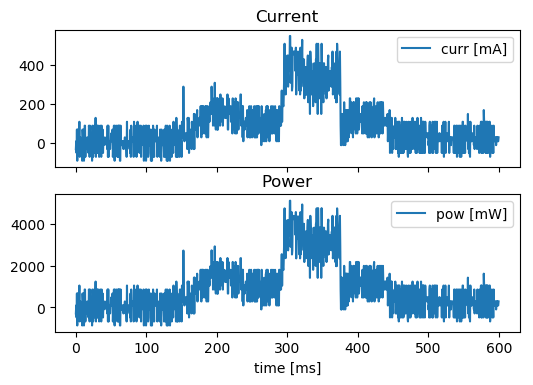

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, dpi=100)

df_val.plot(ax=ax1, x='time [ms]', y='curr [mA]')
ax1.set_title("Current")
df_val.plot(ax=ax2, x='time [ms]', y='pow [mW]')
ax2.set_title("Power")

## Manually selecting when inference happens

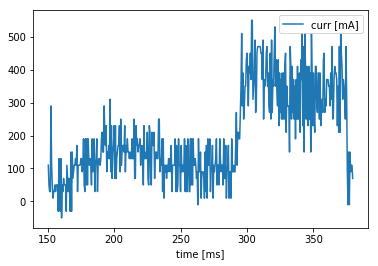

In [8]:
df_val = df_val.loc[df_val['time [ms]'] > 150]
df_val = df_val.loc[df_val['time [ms]'] < 380]

df_val.plot(x='time [ms]', y='curr [mA]')

## Obtaining total energy consumption

In [9]:
energy = df_val['curr [mA]'].sum() * period_ms # mA*ms
energy /= (1000 * 3600) # mAh

energy_tot = df_val['total curr [mA]'].sum() * period_ms # mA*ms
energy_tot /= (1000 * 3600) # mAh

max_power = max(df_val['pow [mW]'])
max_power_tot = max(df_val['total pow [mW]'])

print("Energy consumed during 1 inference:  %f mAh" % energy)
print("Total energy consumed during 1 inference: %f mAh " % energy_tot)
print("Peak power consumption %f mW" % max_power)
print("Total peak power consumption %f mW" % max_power_tot)

Energy consumed during 1 inference:  0.012707 mAh
Total energy consumed during 1 inference: 0.020994 mAh 
Peak power consumption 5098.500000 mW
Total peak power consumption 6303.600000 mW


## Battery analysis

In [10]:
fps_max = 1/(latency/1000.0)
print('Max FPS = %f' % fps_max)

Max FPS = 4.779681


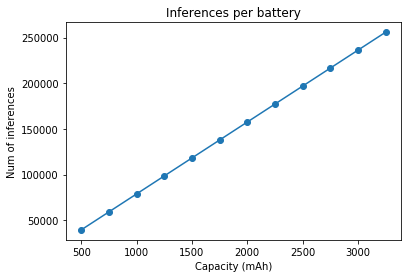

In [11]:
cap = range(500, 3500, 250) # Ranges of battery capacities we're interested on
inf_num = (cap / energy)
plt.title('Inferences per battery')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Num of inferences')
plt.plot(cap, inf_num, marker='o')

In [12]:
print('With 500 mAh, %i inferences can be done' % inf_num[cap.index(500)])
print('With 1000 mAh, %i inferences can be done' % inf_num[cap.index(1000)])
print('With 1500 mAh, %i inferences can be done' % inf_num[cap.index(1500)])

With 500 mAh, 39348 inferences can be done
With 1000 mAh, 78697 inferences can be done
With 1500 mAh, 118045 inferences can be done


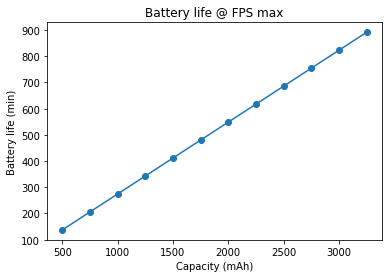

In [13]:
plt.title('Battery life @ FPS max')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Battery life (min)')
batt_life = inf_num/(fps_max * 60)
plt.plot(cap, batt_life, marker='o')

In [14]:
print('A 500 mAh battery lasts %i min' % batt_life[cap.index(500)])
print('A 1000 mAh battery lasts %i min' % batt_life[cap.index(1000)])
print('A 1500 mAh battery lasts %i min' % batt_life[cap.index(1500)])

A 500 mAh battery lasts 137 min
A 1000 mAh battery lasts 274 min
A 1500 mAh battery lasts 411 min
